In [1]:
import os
import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
import cifarEdgesModel
from utils import *
import cv2
from convert_gray import apply_sobel, apply_canny, load_img, class_dict
import matplotlib.pyplot as plt

C:\Users\joyho\AppData\Roaming\Python\Python38\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\joyho\AppData\Roaming\Python\Python38\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\joyho\AppData\Roaming\Python\Python38\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# load model

In [2]:
model = cifarEdgesModel.create_model()
model.load_weights('./weights/lastest/weights-improvement-08-2.19.h5')
model = Model(inputs = model.input,outputs = model.output)

# Prepare Image (2 options)

## Make Fractal

In [3]:
fractal_type = 'Burning_ship' # @param ["Mandelbrot", "Burning_ship", "Julia", "Multibrot"]
z = -0.4 + 0.6 * 1j  # only Julia need
n = 3  # only Multibrot need
x_min, x_max, y_min, y_max = -0.635812184091031, -0.6357047294104714, -0.9967182352675186, -0.9966080482052665

(-0.5, 31.5, 31.5, -0.5)

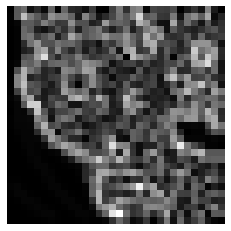

In [4]:
region, x_min, x_max, y_min, y_max = generate_fractals(fractal_type,
                                                       x_min,
                                                       x_max,
                                                       y_min,
                                                       y_max,
                                                       z,
                                                       n,
                                                       crop=False)
region_32 = cv2.resize(region, (32, 32))
region_32 = apply_sobel(region_32)
region_32 = region_32 / 255.0
plt.imshow(region_32, cmap='gray')
plt.axis('off')

## Read Image

In [12]:
x_train_edter = load_img(r'F:\dataset\CIFAR100\cifar100_train_sobel_32',
                         (50000, 32, 32, 1))
# x_val_edter = load_img(r'F:\dataset\CIFAR100\cifar100_val_sobel_32',
#                        (10000, 32, 32, 1))

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [00:59<00:00, 841.50it/s]


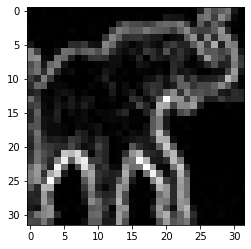

In [21]:
plt.imshow(x_train_edter[9],cmap='gray')
# plt.axis('off')

# Detection Test

In [24]:
model_input = x_train_edter[9] # region_32

**bar graph**

1/1 [==============================] - 0s 18ms/step


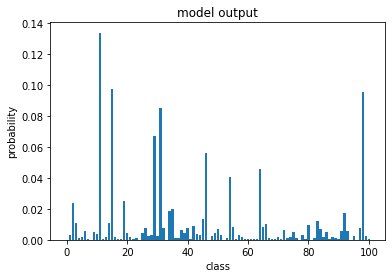

boy 0.1337691694498062


In [25]:
outcome = model.predict(model_input.reshape((1, 32, 32, 1)))[0]
plt.bar(np.arange(0,101),height=outcome)
plt.xlabel('class')
plt.ylabel('probability')
plt.title('model output')
plt.show()
ind = np.argmax(outcome)
conf = outcome[ind]
class_name = class_dict[ind]
print(f'{class_name} {conf}')

**CAM**

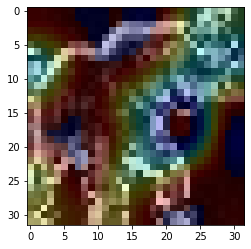

In [31]:
import tensorflow as tf
import tensorflow.keras.backend as K

last_conv_layer = model.get_layer('conv_3_')
heatmap_model =tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
with tf.GradientTape() as gtape:
    img = model_input.reshape((1, 32, 32, 1))
    conv_output, outcome = heatmap_model(img)
    prob = outcome[:, np.argmax(outcome[0])]  # 最大可能性类别的预测概率
    grads = gtape.gradient(prob, conv_output)  # 类别与卷积层的梯度 (1,14,14,512)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))  # 特征层梯度的全局平均代表每个特征层权重
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)  # 权重与特征层相乘，512层求和平均
heatmap = np.maximum(heatmap, 0)
max_heat = np.max(heatmap)
if max_heat == 0:
    max_heat = 1e-10
heatmap /= max_heat
original_img = convert_gray2rgb(model_input*255)
heatmap1 = cv2.resize(heatmap[0], (original_img.shape[1], original_img.shape[0]), interpolation=cv2.INTER_CUBIC)
heatmap1 = np.uint8(255 * heatmap1)
heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)
frame_out = cv2.addWeighted(original_img, 0.75, heatmap1, 0.25, 0)
plt.imshow(frame_out,cmap='gray')
